In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
file_path = r'/content/drive/MyDrive/DL_Project/filtered_txtClsf_data.csv'
data = pd.read_csv(file_path)


In [4]:
# Convert text to lowercase
data['text'] = data['text'].str.lower().astype(str)

# Encode the 'class' column
label_encoder = LabelEncoder()
data['class'] = label_encoder.fit_transform(data['class'])

# Split into training (80%), validation (10%), and test (10%)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Display basic statistics about the splits
train_size, val_size, test_size = len(train_data), len(val_data), len(test_data)

preprocessed_summary = {
    "Train Size": train_size,
    "Validation Size": val_size,
    "Test Size": test_size,
    "Class Distribution in Train": train_data['class'].value_counts().to_dict(),
    "Class Distribution in Validation": val_data['class'].value_counts().to_dict(),
    "Class Distribution in Test": test_data['class'].value_counts().to_dict()
}

preprocessed_summary

{'Train Size': 7028,
 'Validation Size': 879,
 'Test Size': 879,
 'Class Distribution in Train': {1: 4241, 3: 1542, 2: 666, 0: 579},
 'Class Distribution in Validation': {1: 531, 3: 193, 2: 83, 0: 72},
 'Class Distribution in Test': {1: 530, 3: 193, 2: 83, 0: 73}}

In [5]:
# Load LegalBERT tokenizer and model
MODEL_NAME = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(data['class'].unique()))

# Tokenize datasets
def tokenize_data(texts, labels, tokenizer, max_length=512):
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "labels": torch.tensor(labels, dtype=torch.long)
    }

train_encodings = tokenize_data(train_data["text"].tolist(), train_data["class"].tolist(), tokenizer)
val_encodings = tokenize_data(val_data["text"].tolist(), val_data["class"].tolist(), tokenizer)
test_encodings = tokenize_data(test_data["text"].tolist(), test_data["class"].tolist(), tokenizer)

# Prepare PyTorch datasets
class LegalBERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["labels"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

train_dataset = LegalBERTDataset(train_encodings)
val_dataset = LegalBERTDataset(val_encodings)
test_dataset = LegalBERTDataset(test_encodings)

# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Set up Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.085100,1.001812,0.613197,0.480302,0.541260,0.613197
2,0.785300,0.892636,0.648464,0.596073,0.631322,0.648464
3,0.658800,0.902535,0.679181,0.679146,0.685052,0.679181
4,0.405000,0.968834,0.656428,0.649731,0.659064,0.656428
5,0.371600,1.039500,0.688282,0.679283,0.681139,0.688282
6,0.278700,1.073086,0.695108,0.688491,0.685281,0.695108
7,0.175000,1.193078,0.700796,0.694418,0.695824,0.700796
8,0.247700,1.244689,0.693970,0.693123,0.693127,0.693970
9,0.179500,1.378738,0.678043,0.678632,0.685476,0.678043
10,0.207000,1.349406,0.698521,0.693290,0.690521,0.698521


Test Results: {'eval_loss': 1.3247575759887695, 'eval_accuracy': 0.6791808873720137, 'eval_f1': 0.676216742533059, 'eval_precision': 0.6870079419831977, 'eval_recall': 0.6791808873720137, 'eval_runtime': 20.3786, 'eval_samples_per_second': 43.134, 'eval_steps_per_second': 2.699, 'epoch': 10.0}


In [6]:
# Tokenize all texts in the dataset to analyze their lengths in tokens
token_lengths = data["text"].apply(lambda x: len(tokenizer.tokenize(x)))

# Add token lengths to the dataset for analysis
data["token_length"] = token_lengths

# Get summary statistics for token lengths
token_length_stats = token_lengths.describe()

# Check how many texts exceed the 512-token limit
texts_exceeding_limit = (token_lengths > 512).sum()

# Prepare a summary for text length analysis
text_length_analysis = {
    "Total Samples": len(data),
    "Average Token Length": token_length_stats["mean"],
    "Max Token Length": token_length_stats["max"],
    "Min Token Length": token_length_stats["min"],
    "Texts Exceeding 512 Tokens": texts_exceeding_limit,
    "Percentage Exceeding 512 Tokens": (texts_exceeding_limit / len(data)) * 100
}

text_length_analysis


{'Total Samples': 8786,
 'Average Token Length': 199.5130890052356,
 'Max Token Length': 457.0,
 'Min Token Length': 29.0,
 'Texts Exceeding 512 Tokens': 0,
 'Percentage Exceeding 512 Tokens': 0.0}

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract training logs and store in a DataFrame
training_logs = trainer.state.log_history

# Create a list to store epoch-wise results
results = []
for log in training_logs:
    if "epoch" in log:
        epoch_result = {
            "Epoch": log["epoch"],
            "Training Loss": log["loss"] if "loss" in log else None,
            "Validation Loss": log["eval_loss"] if "eval_loss" in log else None,
            "Accuracy": log["eval_accuracy"] if "eval_accuracy" in log else None,
            "F1": log["eval_f1"] if "eval_f1" in log else None,
            "Precision": log["eval_precision"] if "eval_precision" in log else None,
            "Recall": log["eval_recall"] if "eval_recall" in log else None,
        }
        results.append(epoch_result)

# Convert results into a DataFrame
results_df = pd.DataFrame(results).dropna(subset=["Training Loss"]).reset_index(drop=True)
results_df = results_df[results_df["Epoch"].isin(range(1, 11))].reset_index(drop=True)
results_df

,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.0,1.0851,NaN,NaN,NaN,NaN,NaN
1,2.0,0.7853,NaN,NaN,NaN,NaN,NaN
2,3.0,0.6588,NaN,NaN,NaN,NaN,NaN
3,4.0,0.4050,NaN,NaN,NaN,NaN,NaN
4,5.0,0.3716,NaN,NaN,NaN,NaN,NaN
5,6.0,0.2787,NaN,NaN,NaN,NaN,NaN
6,7.0,0.1750,NaN,NaN,NaN,NaN,NaN
7,8.0,0.2477,NaN,NaN,NaN,NaN,NaN
8,9.0,0.1795,NaN,NaN,NaN,NaN,NaN
9,10.0,0.2070,NaN,NaN,NaN,NaN,NaN


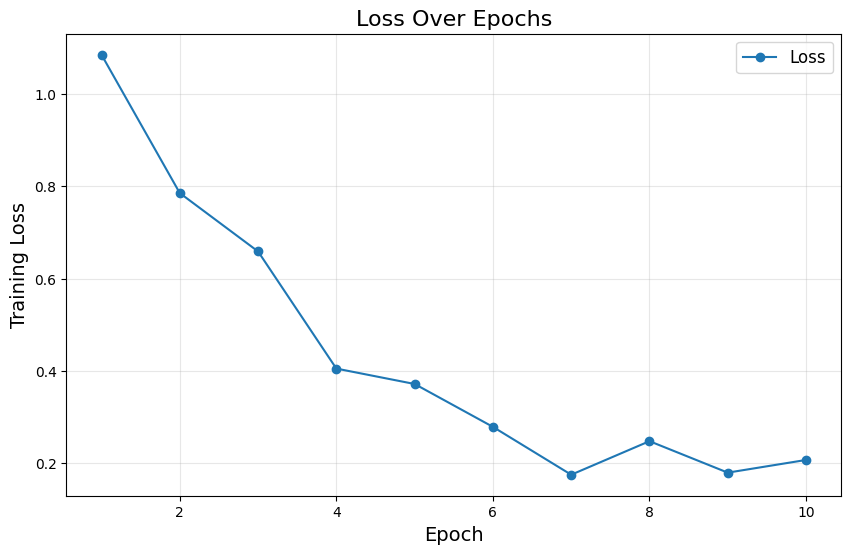

In [26]:
# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(results_df["Epoch"], results_df["Training Loss"], label="Loss", marker="o")

# Add titles and labels
plt.title("Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [27]:
# Define the directory to save the fine-tuned model
save_directory = "/content/drive/MyDrive/DL_Project/legalbert-citation-classification-model_v2"

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to /content/drive/MyDrive/DL_Project/legalbert-citation-classification-model_v2


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify the path to the extracted model
local_model_path = "/content/drive/MyDrive/DL_Project/legalbert-citation-classification-model_v2"

# Load the fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model = AutoModelForSequenceClassification.from_pretrained(local_model_path)


In [29]:
# Tokenize the test dataset
def tokenize_data(texts, labels, tokenizer, max_length=512):
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "labels": torch.tensor(labels, dtype=torch.long),
    }

test_encodings = tokenize_data(
    test_data["text"].tolist(),
    test_data["class"].tolist(),
    tokenizer,
)

# Prepare the test dataset
class LegalBERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["labels"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

test_dataset = LegalBERTDataset(test_encodings)


In [30]:
from transformers import Trainer

# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Create a Trainer object for evaluation
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
)

# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Test Results: {'eval_loss': 1.3247575759887695, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.6791808873720137, 'eval_f1': 0.676216742533059, 'eval_precision': 0.6870079419831977, 'eval_recall': 0.6791808873720137, 'eval_runtime': 20.001, 'eval_samples_per_second': 43.948, 'eval_steps_per_second': 5.5}


In [31]:
test_results_df = pd.DataFrame([test_results])
test_results_df

,eval_loss,eval_model_preparation_time,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.324758,0.0033,0.679181,0.676217,0.687008,0.679181,20.001,43.948,5.5


In [32]:
# Get predictions from the model
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

In [33]:
predicted_classes = label_encoder.inverse_transform(predicted_labels)
actual_classes = label_encoder.inverse_transform(true_labels)

In [34]:
# Create a DataFrame for results
multiclass_results_df = pd.DataFrame({
    "Text": test_data["text"].tolist(),  # Original text from the test data
    "Actual Class": actual_classes,
    "Predicted Class": predicted_classes
})

# Display the first few rows of the DataFrame
multiclass_results_df

,Text,Actual Class,Predicted Class
0,"20 in the first place, there is some doubt as ...",referred to,referred to
1,federal magistrate raphael characterised the g...,referred to,referred to
2,while i found the second respondent not liable...,cited,referred to
3,63 the applicant should understand that the ki...,cited,cited
4,26 now that the test for legal professional pr...,referred to,referred to
...,...,...,...
874,it is unnecessary for present purposes to reso...,cited,referred to
875,30 i am not prepared to make an order in terms...,applied,cited
876,41 if the respondents sought to enforce paymen...,cited,cited
877,10 this section has been the subject of previo...,cited,cited


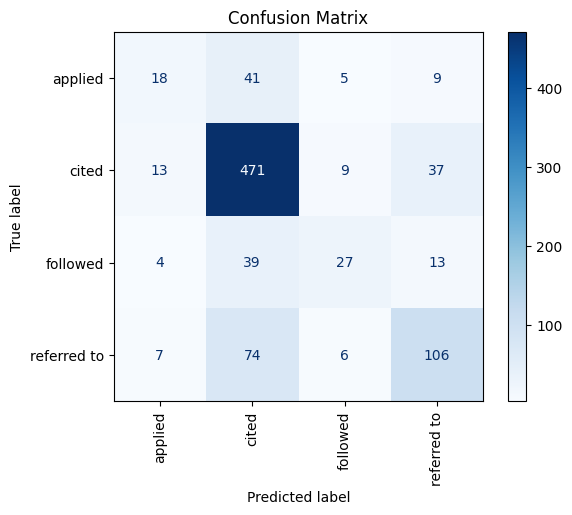

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()


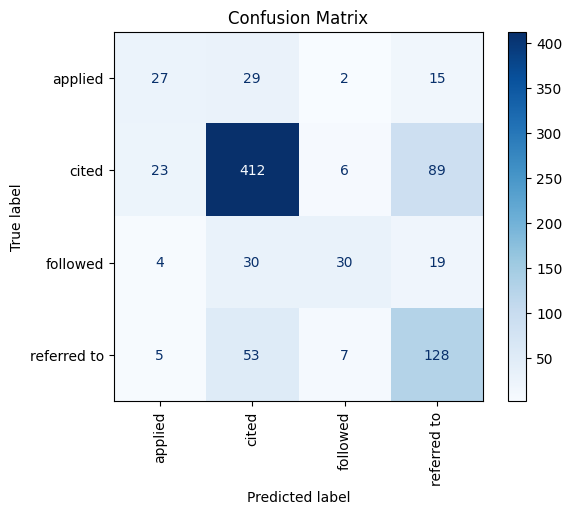

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
def load_model_and_tokenizer(local_model_path):
    tokenizer = AutoTokenizer.from_pretrained(local_model_path)
    model = AutoModelForSequenceClassification.from_pretrained(local_model_path)
    return tokenizer, model

# Function to classify a single text
def classify_text(text, tokenizer, model, category_labels=None):
    """
    Classifies the input text into one of the predefined categories.

    Args:
        text (str): The input text to classify.
        tokenizer: The tokenizer loaded from the model.
        model: The fine-tuned LegalBERT model for classification.
        category_labels (list): Optional list of category labels. If not provided, uses default.

    Returns:
        str: The predicted category for the input text.
    """
    # Default category labels
    if category_labels is None:
        category_labels = ["referred to", "cited", "applied", "followed"]

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass through the model
    outputs = model(**inputs)

    # Get predicted class index
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Return the predicted category
    return category_labels[predicted_class]

# Main function for user interaction
def main():
    # Path to the fine-tuned model
    local_model_path = "/content/drive/MyDrive/DL_Project/legalbert-fine-tuned"

    # Load model and tokenizer
    tokenizer, model = load_model_and_tokenizer(local_model_path)

    print("Legal Text Classifier")
    print("Enter your legal text below (type 'exit' to quit):")

    while True:
        # Take user input
        user_input = input("Input text: ")

        # Exit condition
        if user_input.lower() == "exit":
            print("Exiting the program.")
            break

        # Classify the input text
        predicted_category = classify_text(user_input, tokenizer, model)
        print(f"Predicted Category: {predicted_category}\n")

# Run the main function
if __name__ == "__main__":
    main()


Legal Text Classifier
Enter your legal text below (type 'exit' to quit):
Input text: 30 Ordinarily that discretion will be exercised so that costs follow the event and are awarded on a party and party basis. A departure from normal practice to award indemnity costs requires some special or unusual feature in the case: Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Ltd (No 2) [2002] FCA 224 ; (2002) 190 ALR 121 at [11] (Weinberg J) citing Colgate Palmolive Co v Cussons Pty Ltd (1993) 46 FCR 225 at 233 (Sheppard J).
Predicted Category: cited

Input text: exit
Exiting the program.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Function to classify a single text
def classify_text(text, model_path):
    """
    Classifies the input text into one of the predefined categories.

    Args:
        text (str): The input text to classify.
        model_path (str): The path to the fine-tuned LegalBERT model.
        category_labels (list): List of category labels.

    Returns:
        str: The predicted category for the input text.
    """
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    category_labels = ["referred to", "cited", "applied", "followed"]

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass through the model
    outputs = model(**inputs)

    # Get predicted class index
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Return the predicted category
    return category_labels[predicted_class]

# Main function for user interaction
def main():
    # Path to the fine-tuned model
    model_path = "/content/drive/MyDrive/DL_Project/legalbert-citation-classification-model_v2"

    # Define category labels


    print("Legal Text Classifier")
    print("Enter your legal text below (type 'exit' to quit):")

    while True:
        # Take user input
        user_input = input("Input text: ")

        # Exit condition
        if user_input.lower() == "exit":
            print("Exiting the program.")
            break

        # Classify the input text
        predicted_category = classify_text(user_input, model_path)
        print(f"Predicted Category: {predicted_category}\n")

# Run the main function
if __name__ == "__main__":
    main()

Legal Text Classifier
Enter your legal text below (type 'exit' to quit):
Input text: 30 Ordinarily that discretion will be exercised so that costs follow the event and are awarded on a party and party basis. A departure from normal practice to award indemnity costs requires some special or unusual feature in the case: Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Ltd (No 2) [2002] FCA 224 ; (2002) 190 ALR 121 at [11] (Weinberg J) citing Colgate Palmolive Co v Cussons Pty Ltd (1993) 46 FCR 225 at 233 (Sheppard J).
Predicted Category: cited

Input text: exit
Exiting the program.
